In [21]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import plotly_express as px

In [22]:
metadata_df = pd.read_csv("train_metadata.csv", index_col="sample")
data_df = pd.read_csv("train_data.csv",  index_col="sample")

In [23]:
metadata_df.columns

Index(['baboon_id', 'collection_date', 'sex', 'age', 'social_group',
       'group_size', 'rain_month_mm', 'season', 'hydro_year', 'month',
       'diet_PC1', 'diet_PC2', 'diet_PC3', 'diet_PC4', 'diet_PC5', 'diet_PC6',
       'diet_PC7', 'diet_PC8', 'diet_PC9', 'diet_PC10', 'diet_PC11',
       'diet_PC12', 'diet_PC13'],
      dtype='object')

full correlation between moth and season - no need to take both
6-10 - wet else dry.



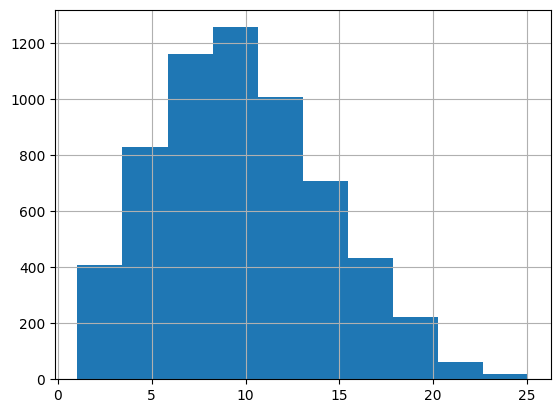

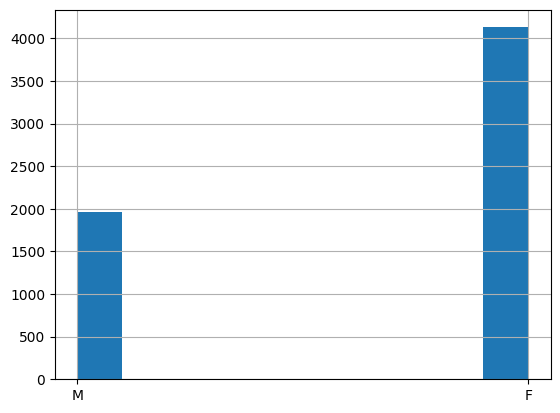

In [24]:
metadata_df["age"].hist()

plt.show()
metadata_df["sex"].hist()

plt.show()


In [25]:
metadata_df_M = metadata_df[metadata_df["sex"]=="M"]
metadata_df_F = metadata_df[metadata_df["sex"]=="F"]

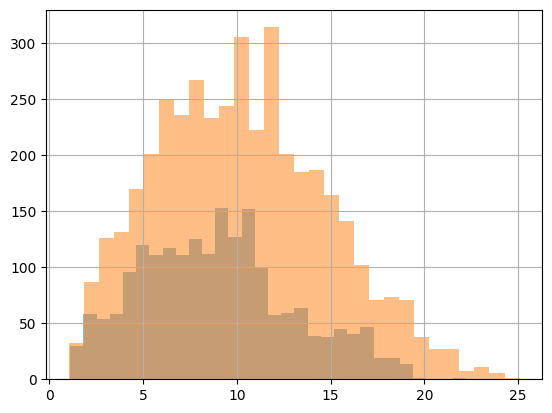

In [26]:
metadata_df_M["age"].hist(bins = 30, alpha=0.5)

metadata_df_F["age"].hist(bins=30, alpha=0.5)

plt.show()

In [27]:
def aitchison_normalization(df):
    dataf = df.copy()
    D = dataf.shape[1]
    values = dataf.values
    values[values == 0] = 10 ** - 100
    
    for i, row in enumerate(values):
        gp = np.sum(np.log(row**(1/D)))
        values[i] = np.log(row)-gp


    
    return pd.DataFrame(values, columns= dataf.columns, index=dataf.index)

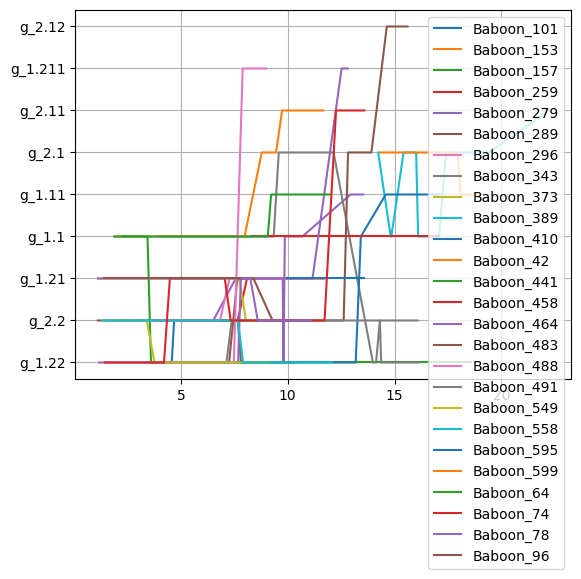

In [28]:
for baboon in metadata_df_M["baboon_id"].unique():
    age = metadata_df_M["age"][metadata_df_M["baboon_id"] == baboon]
    social_group = metadata_df_M["social_group"][metadata_df_M["baboon_id"] == baboon]
    plt.plot(age, social_group, label=baboon)
    
plt.grid()
plt.legend()
plt.show()

In [29]:
# make sure the data is sorted by sample date
metadata_df_M.sort_values(by=["baboon_id","collection_date"], inplace=True)


C:\Users\tomer\AppData\Local\Temp\ipykernel_16024\3969196945.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [30]:
# for each baboon - summig  up the number of social group change over the years.
number_of_group_change_M = []
for baboon in metadata_df_M["baboon_id"].unique():
    baboon_df = pd.DataFrame({"social_group":metadata_df_M["social_group"][metadata_df_M["baboon_id"]==baboon]})
    baboon_df["next_social_group"] = baboon_df["social_group"].shift(1)
    group_change = (baboon_df["next_social_group"] != baboon_df["social_group"]).astype('int')
    number_of_group_change_M.append(np.sum(group_change)-1)
    
number_of_group_change_F = []
for baboon in metadata_df_F["baboon_id"].unique():
    baboon_df = pd.DataFrame({"social_group":metadata_df_F["social_group"][metadata_df_F["baboon_id"]==baboon]})
    baboon_df["next_social_group"] = baboon_df["social_group"].shift(1)
    group_change = (baboon_df["next_social_group"] != baboon_df["social_group"]).astype('int')
    number_of_group_change_F.append(np.sum(group_change)-1)



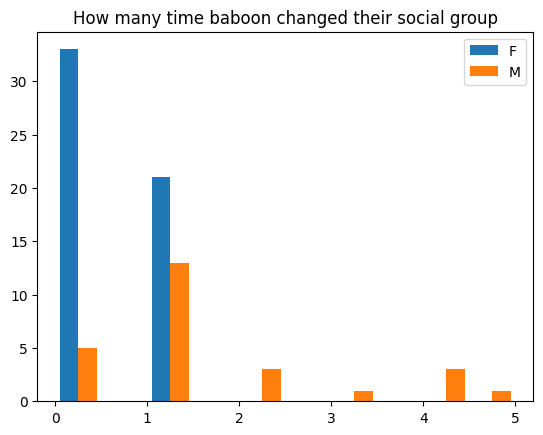

In [31]:
plt.hist([number_of_group_change_F,number_of_group_change_M], label=["F","M"])
plt.legend()
plt.title("How many time baboon changed their social group")
plt.show()

In [32]:
np.mean(metadata_df.groupby("baboon_id")["collection_date"].count())

76.2

1. clustering baboons by averege microbiome profile.
2. changes in samples throughout time for each baboon.

In [33]:
# add baboon_id column
data_df["baboon_id"] = metadata_df["baboon_id"]

data_df_avg = aitchison_normalization(data_df.groupby("baboon_id").mean())


100%|██████████| 9/9 [00:03<00:00,  2.52it/s]


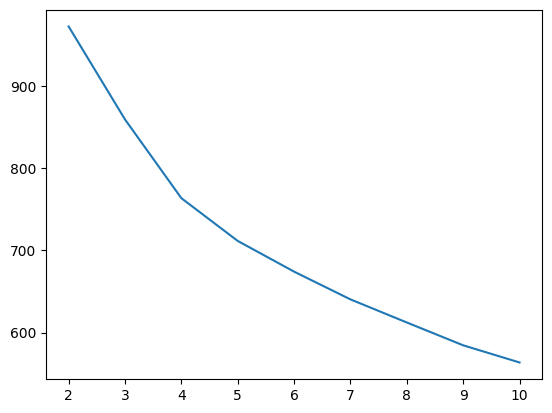

In [34]:

from sklearn.cluster import KMeans


distortions = []
for k in tqdm(range(2, 11)):
    val = 0
    for _ in range(10):
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data_df_avg.values)
        val += kmeans.inertia_
    
    distortions.append(val/10)
plt.plot(range(2,11),distortions)



In [35]:
kmean = KMeans(n_clusters=5, n_init=100)
labels = kmean.fit(data_df_avg.values).labels_

In [36]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
results = pd.DataFrame(pca.fit_transform(data_df_avg), columns=["PC1", "PC2", "PC3"])

In [37]:
px.scatter_3d(results.iloc[:,:3], x="PC1", y="PC2", z="PC3", color=labels)

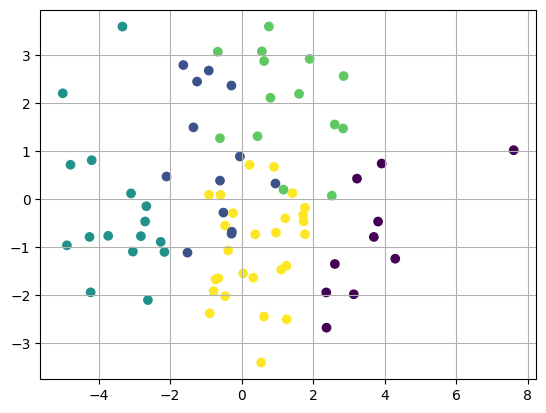

In [38]:
pca = PCA(n_components=2)
results = pca.fit_transform(data_df_avg).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

In [39]:
import umap

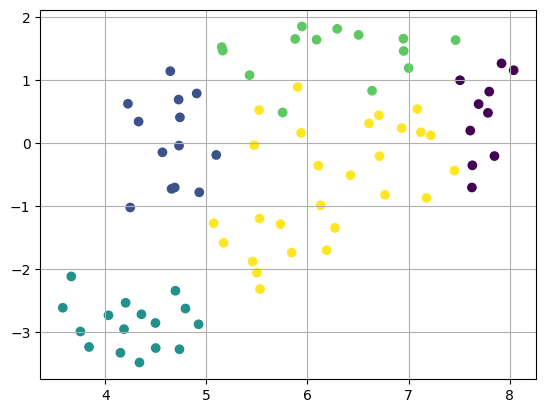

In [40]:
reducer = umap.UMAP()
results = reducer.fit_transform(data_df_avg.values).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

In [41]:
reducer = umap.UMAP(n_components=3)
results = reducer.fit_transform(data_df_avg.values)

# px.scatter_3d(pd.DataFrame(results, columns=["UMAP1", "UMAP2", "UMAP3"]), x="UMAP1", y="UMAP2", z="UMAP3", color=labels).write_html("umap_cluster5.html")
px.scatter_3d(pd.DataFrame(results, columns=["UMAP1", "UMAP2", "UMAP3"]), x="UMAP1", y="UMAP2", z="UMAP3", color=labels)

In [42]:
metadata_df_D_F = metadata_df_F[metadata_df_F["season"]=="dry"]
metadata_df_W_F = metadata_df_F[metadata_df_F["season"]=="wet"]
metadata_df_D_M = metadata_df_M[metadata_df_M["season"]=="dry"]
metadata_df_W_M = metadata_df_M[metadata_df_M["season"]=="wet"]

In [43]:
data_df["season"] = metadata_df["season"]
data_df_avg_season = data_df.groupby(["baboon_id","season"]).mean()


In [44]:
data_df_avg_M_D = data_df_avg_season.loc[(metadata_df_M["baboon_id"].unique(),'dry'),:]
data_df_avg_M_W = data_df_avg_season.loc[(metadata_df_M["baboon_id"].unique(),'wet'),:]
data_df_avg_F_D = data_df_avg_season.loc[(metadata_df_F["baboon_id"].unique(),'dry'),:]
data_df_avg_F_W = data_df_avg_season.loc[(metadata_df_F["baboon_id"].unique(),'wet'),:]

In [45]:
data_df_avg_M_D["sex"] = 0
data_df_avg_F_D["sex"] = 1
data_df_avg_M_W["sex"] = 0
data_df_avg_F_W["sex"] = 1

data_df_avg_D = pd.concat([data_df_avg_M_D, data_df_avg_F_D])
data_df_avg_W = pd.concat([data_df_avg_M_W, data_df_avg_F_W])




C:\Users\tomer\AppData\Local\Temp\ipykernel_16024\2837600465.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tomer\AppData\Local\Temp\ipykernel_16024\2837600465.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\tomer\AppData\Local\Temp\ipykernel_16024\2837600465.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [47]:
labels = data_df_avg_D["sex"].values
pca = PCA(n_components=3)
results = pca.fit_transform(aitchison_normalization(data_df_avg_D.drop(columns="sex")))


px.scatter_3d(pd.DataFrame(results, columns=["PC1", "PC2", "PC3"]), x="PC1", y="PC2", z="PC3", color=labels)



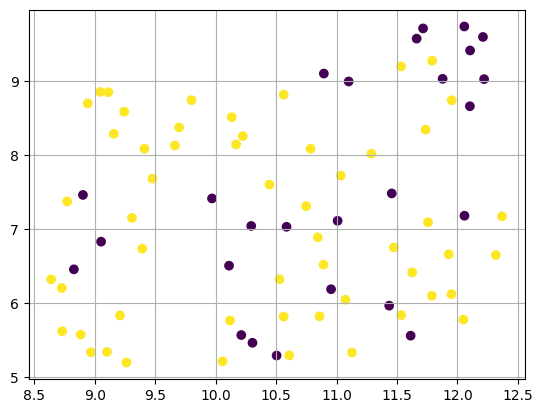

In [48]:
reducer = umap.UMAP()
results = reducer.fit_transform(aitchison_normalization(data_df_avg_D.drop(columns="sex"))).transpose()

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

In [49]:
labels = data_df_avg_W["sex"].values
pca = PCA(n_components=3)
results = pca.fit_transform(aitchison_normalization(data_df_avg_W.drop(columns="sex")))


px.scatter_3d(pd.DataFrame(results, columns=["PC1", "PC2", "PC3"]), x="PC1", y="PC2", z="PC3", color=labels)

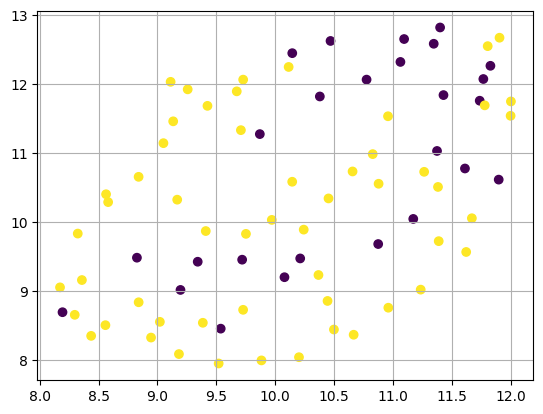

In [50]:
reducer = umap.UMAP()
results = reducer.fit_transform(aitchison_normalization(data_df_avg_W.drop(columns="sex"))).T

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()


In [51]:
labels = (data_df_avg_season.reset_index()["season"]=='dry').astype(int).values
pca = PCA(n_components=3)
results = pca.fit_transform(aitchison_normalization(data_df_avg_season))
px.scatter_3d(pd.DataFrame(results, columns=["PC1", "PC2", "PC3"]), x="PC1", y="PC2", z="PC3", color=labels)



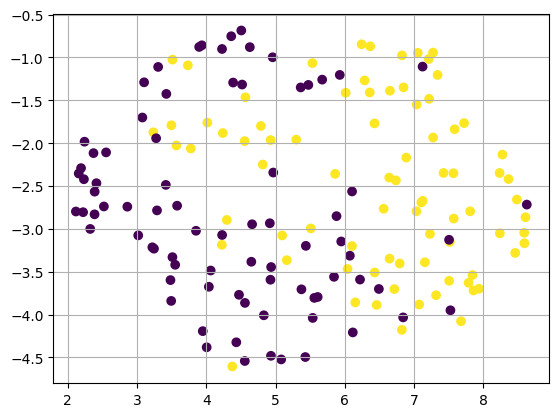

In [52]:
reducer = umap.UMAP()
results = reducer.fit_transform(aitchison_normalization(data_df_avg_season)).T

plt.scatter(results[0], results[1], c=labels)
plt.grid()
plt.show()

In [53]:
Df = data_df_avg_D.copy().reset_index(level=1, drop=True)
Wf = data_df_avg_W.copy().reset_index(level=1, drop=True)

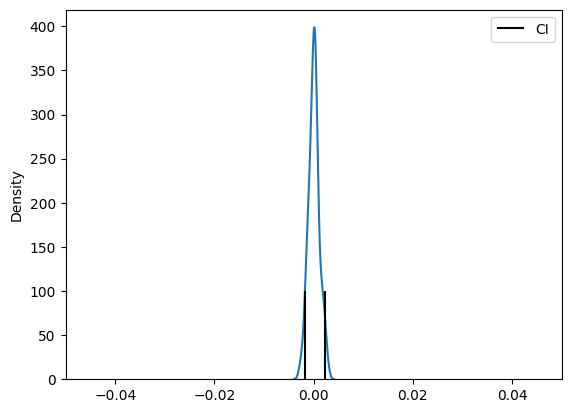

In [54]:
diff = []

for baboon in metadata_df["baboon_id"].unique():
    diff.append(Df.loc[baboon]- Wf.loc[baboon].values)
diff = np.array(diff).T
# avg = [diff[i].mean() for i in range(len(diff))]
# avg.sort()
# print(avg)

# for row in np.array(diff).T:
row = diff[22]
row.sort()
sns.kdeplot(row)
plt.vlines(np.percentile(row, 2.5), ymin=0,ymax=100, color ="black", label="CI")
plt.vlines(np.percentile(row, 97.5), ymin=0,ymax=100, color ="black")
plt.legend()
plt.xlim(-0.05, 0.05)
plt.show()


### changes in samples throughout time for each baboon.

In [55]:
data_df["collection_date"] = metadata_df["collection_date"]
data_df.sort_values(by=["baboon_id","collection_date"],inplace=True)

In [56]:
df = data_df[data_df["baboon_id"]=="Baboon_101"]